`get_data(filepath)`: get the dataset  

`sum_norm(df)`: sum normailise the dataset 

`get_valid_subset(norm_df)`: get the subset that contains valid content in the answers 

`problem_processing(subset['Problem'])`: processing the problem text in the normalised valid subset

`separate_text(problems)`: separate the text in the problems

`separate_numbers(problems)`: separate the numbers in the problems

`minmax_norm(array)`: min-max normailise the sequence of numbers

## 1. Get the dataset ##

In [197]:
import pandas as pd
import numpy as np
import json

def get_data(filepath):
    
    with open(filepath) as f:
        data = json.loads(f.read())
    df = pd.DataFrame(data)
    
    def get_options(df):
        # get the content of the options from the dataset
        opt_label = ['a', 'b', 'c', 'd', 'e']
        opts = list()
        for i in range(len(df)):
            options = df.iloc[i]['options']+" ,"
            answers = list()
            for label in opt_label:
                index_s = options.find(label+" ) ")+3
                index_len = options[index_s:].find(',')
                ans = options[index_s:index_s+index_len]
                answers.append(ans)
            opts.append(list(answers))
        opts = pd.DataFrame(opts, columns=['option_'+l for l in opt_label])
        return opts
    
    opts = get_options(df)
    new_data = df[['Problem', 'correct', 'category']].join(opts)
    return new_data


In [198]:
filepath = 'dataset/MathQA/train.json'
train_df = get_data(filepath)
train_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,a,gain,rs . 400,rs . 300,rs . 500,rs . 350,none of these
1,average age of students of an adult school is ...,d,general,1200,120,360,240,none of these
2,sophia finished 2 / 3 of a book . she calculat...,b,general,229,270,877,266,281
3,120 is what percent of 50 ?,b,gain,5 %,240 %,50 %,2 %,500 %
4,there are 10 girls and 20 boys in a classroom ...,a,other,1 / 2,1 / 3,1 / 5,10 / 30,2 / 5
...,...,...,...,...,...,...,...,...
29832,a man invests some money partly in 10 % stock ...,a,other,1 : 2,3 : 5,4 : 5,16 : 15,none
29833,"average of 10 matches is 32 , how many runs on...",d,general,a ) 70,b ) 76,c ) 78,d ) 98,e ) 88
29834,solve below question 2 x + 1 = - 23,c,general,- 8,- 9,- 12,- 4,12
29835,calculate 85184 ÷ ? = 352,b,general,241,242,244,247,240


## 2. Normalization

#### 1) normalizing functions: 30^10 2/3 10% 5:8

In [199]:
import re

# def remove_quotes(sen):
#     return sen[2:-2]

def add_space(sen):
    return " "+sen+" "

def replace_fraction(sen):
    # replace all string like "2 / 3 "
    pattern = re.compile(r'[0-9]+\s\/\s[0-9]+\s')    
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' / ')
            if int(nums[1]) != 0:
                new_results.append(str(int(nums[0])/int(nums[1]))[:8]+' ')
            else:
                new_results.append(str(np.NaN))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_percentage(sen):
    # replace all string like "20 %"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s%')   
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' ')
            new_results.append(str(round(float(nums[0])/100, 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_ratio(sen):
    # replace all string like " 2 : 3" "0.5 : 0.33 : 0.25"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s\:\s[0-9]+\.?[0-9]*')
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' : ')
            new_results.append(str(round(float(nums[0])/(float(nums[0])+float(nums[1])), 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_power(sen):
    # replace all string like "  30 ^ 10 "
    pass
    return sen

def replace_numword(sen):
    sen = sen.replace(' one ', ' 1 ')
    sen = sen.replace(' two ', ' 2 ')
    sen = sen.replace(' three ', ' 3 ')
    sen = sen.replace(' four ', ' 4 ')
    sen = sen.replace(' five ', ' 5 ')
    sen = sen.replace(' six ', ' 6 ')
    sen = sen.replace(' seven ', ' 7 ')
    sen = sen.replace(' eight ', ' 8 ')
    sen = sen.replace(' nine ', ' 9 ')
    sen = sen.replace(' ten ', ' 10 ')
    sen = sen.replace(' eleven ', ' 11 ')
    sen = sen.replace(' twelve ', ' 12 ')
    sen = sen.replace(' thirteen ', ' 13 ')
    sen = sen.replace(' fourteen ', ' 14 ')
    return sen

def replace_minus(sen):
    # replace all string like "- 20.5"
    pattern = re.compile(r'\-\s[0-9]+\.?[0-9]*')   
    results = pattern.findall(sen)
    
    if results != None:
        for i in results:
            sen = sen.replace(i, i.replace(" ", "", 1))
    return sen
    
def replace_punc(sen):
    # replace punctuation like "'" "." "|"
    sen = re.sub(r'\s[^\w\s]\s', ' ', sen)
    return sen


#### 2) normalise options

In [200]:
def answers_processing(answers):    
    # normalizing the correct answers
    # get the correct answers array that may contain NaN
    
    answers = answers.apply(replace_power)
    answers = answers.apply(replace_fraction)
    answers = answers.apply(replace_percentage)
    answers = answers.apply(replace_ratio)
    answers = answers.apply(replace_numword)
    answers = answers.apply(replace_minus)

    def separate_ans_numbers(sen):
        numbers = re.search(r'\-?[0-9]+\.?[0-9]*', sen)
        if numbers:
            numbers = numbers.group()
            return round(float(numbers), 4)
        else:
            return 
    answers = answers.apply(separate_ans_numbers)
    return answers

In [374]:
train_df[train_df.Problem.str.contains('if | 4 x + 14 | = 46')]

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
5,an empty fuel tank with a capacity of 218 gall...,a,gain,122,150,100,80,50
13,a salesman â € ™ s terms were changed from a f...,c,general,s . 14,s . 12,s . 16,s . 40,s . 50
14,a rectangular floor that measures 15 meters by...,c,geometry,$ 200,$ 240,$ 360,$ 960,$ 1
22,"in the above number , a and b represent the te...",e,general,0,5,10,15,20
26,if a bicyclist in motion increases his speed b...,c,general,10 %,40 %,43 %,64 %,140 %
...,...,...,...,...,...,...,...,...
29824,"drum x is 1 / 2 full of oil and drum y , which...",c,general,2 / 3,5 / 6,7 / 12,11 / 12,17 / 24
29828,if 9 engines consume 24 metric tonnes of coal ...,c,physics,22,24,26,28,none of them
29830,if 16 percent of the students at a certain sch...,e,general,95,90,85,80,64
29831,a man sitting in a train which is traveling at...,c,physics,52 kmph,56 kmph,60 kmph,62 kmph,72 kmph


In [377]:
# replace correct label
def num_label(s):
    if s == 'a':
        return 0
    elif s == 'b':
        return 1
    elif s == 'c':
        return 2
    elif s == 'd':
        return 3
    else:
        return 4
    
def sum_norm(train_df):
    norm_train_df = train_df.copy()
    # standardise all the options
    for i in range(5):
        norm_train_df.iloc[:, 3+i] = answers_processing(norm_train_df.iloc[:, 3+i])
    
    # normalise all the options
    option_df = pd.DataFrame(norm_train_df.iloc[:, 3:8])
    opt_sum = option_df.sum(axis=1)
    norm_train_df.iloc[:, 3:8] = option_df.div(opt_sum, axis=0)
        
    norm_train_df['correct'] = norm_train_df['correct'].apply(num_label)

    return norm_train_df
        

In [378]:
norm_train_df = sum_norm(train_df)
norm_train_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,0,gain,0.258065,0.193548,0.322581,0.225806,NaN
1,average age of students of an adult school is ...,3,general,0.625000,0.062500,0.187500,0.125000,NaN
2,sophia finished 2 / 3 of a book . she calculat...,1,general,0.119085,0.140406,0.456058,0.138326,0.146126
3,120 is what percent of 50 ?,1,gain,0.006274,0.301129,0.062735,0.002509,0.627353
4,there are 10 girls and 20 boys in a classroom ...,0,other,0.283030,0.188667,0.113212,0.188667,0.226424
...,...,...,...,...,...,...,...,...
29832,a man invests some money partly in 10 % stock ...,0,other,0.199724,0.224712,0.266299,0.309264,NaN
29833,"average of 10 matches is 32 , how many runs on...",3,general,0.170732,0.185366,0.190244,0.239024,0.214634
29834,solve below question 2 x + 1 = - 23,2,general,0.380952,0.428571,0.571429,0.190476,-0.571429
29835,calculate 85184 ÷ ? = 352,1,general,0.198517,0.199341,0.200988,0.203460,0.197694


## 3. Get the content of correct answers from the options 

In [520]:
def get_valid_subset(norm_df):
    # get the subset that the correct answer is not NaN, inf
    ans = np.empty((norm_df.shape[0], 1))
    for i in range(len(norm_df)):
        ans[i] = norm_df.iloc[i, 3+norm_df.iloc[i, 1]]
    
    # remove NaN
    sub_train_df = norm_df[~np.isnan(ans)].reset_index(drop=True)
    ans_train = ans[~np.isnan(ans)]
#     print(sub_train_df.shape)
    
    # remove INF
    sub_train_df_2 = sub_train_df[~np.isinf(ans_train)].reset_index(drop=True)
    ans_train_2 = ans_train[~np.isinf(ans_train)]
#     print(sub_train_df_2.shape)
    
    return sub_train_df_2, ans_train_2

sub_train_df = get_valid_subset(norm_train_df)[0]
ans_train = get_valid_subset(norm_train_df)[1]

In [521]:
print(sub_train_df.shape)
sub_train_df

(29639, 8)


,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,0,gain,0.258065,0.193548,0.322581,0.225806,NaN
1,average age of students of an adult school is ...,3,general,0.625000,0.062500,0.187500,0.125000,NaN
2,sophia finished 2 / 3 of a book . she calculat...,1,general,0.119085,0.140406,0.456058,0.138326,0.146126
3,120 is what percent of 50 ?,1,gain,0.006274,0.301129,0.062735,0.002509,0.627353
4,there are 10 girls and 20 boys in a classroom ...,0,other,0.283030,0.188667,0.113212,0.188667,0.226424
...,...,...,...,...,...,...,...,...
29634,a man invests some money partly in 10 % stock ...,0,other,0.199724,0.224712,0.266299,0.309264,NaN
29635,"average of 10 matches is 32 , how many runs on...",3,general,0.170732,0.185366,0.190244,0.239024,0.214634
29636,solve below question 2 x + 1 = - 23,2,general,0.380952,0.428571,0.571429,0.190476,-0.571429
29637,calculate 85184 ÷ ? = 352,1,general,0.198517,0.199341,0.200988,0.203460,0.197694


In [522]:
print(ans_train.shape)
ans_train[29288]

(29639,)


0.2903225806451613

## 4. Processing the problems and separate the text and numbers

#### 1) normalize the numbers and remove the punctuations

In [523]:
def problem_processing(problem):
    # processing the problems and normalize the numbers in the problem
    problem = problem.apply(add_space)
    problem = problem.apply(replace_power)
    problem = problem.apply(replace_fraction)
    problem = problem.apply(replace_percentage)
    problem = problem.apply(replace_ratio)
    problem = problem.apply(replace_numword)
    problem = problem.apply(replace_minus)
    problem = problem.apply(replace_punc)
    return problem

train_problems = problem_processing(sub_train_df['Problem'])

In [524]:
print(train_problems[28691])

 a 8 w 2 is the x y coordinate of point located on the parabola y x 2 17 what is the value of w 


#### 2) separate text and numbers in problems

In [525]:
def separate_numbers(sen):    
    pattarn = re.compile(r'\s\-?[0-9]+\.?[0-9]*\s')
    numbers = pattarn.findall(sen)
    numbers = np.array([round(float(i), 4) for i in numbers])
    return numbers
    
def separate_text(sen):
    pattarn = re.compile(r'\-?[0-9]+\.?[0-9]*')
    numbers = pattarn.findall(sen)
    for i in numbers:
        sen = sen.replace(" "+i+" ", " ")
    return sen    

text = train_problems.apply(separate_text)
print(text)

numbers = train_problems.apply(separate_numbers)
print(numbers)

0         the banker s gain of a certain sum due years ...
1         average age of students of an adult school is...
2         sophia finished of a book she calculated that...
3                                      is what percent of 
4         there are girls and boys in a classroom what ...
                               ...                        
29634     a man invests some money partly in stock at a...
29635     average of matches is how many runs should sh...
29636                              solve below question x 
29637                                         calculate ? 
29638     a vending machine is designed to dispense oun...
Name: Problem, Length: 29639, dtype: object
0                                         [3.0, 0.1, 36.0]
1                                 [40.0, 120.0, 32.0, 4.0]
2                                           [0.6667, 90.0]
3                                            [120.0, 50.0]
4                                             [10.0, 20.0]
            

In [526]:
numbers[29288]

array([1.23456789e+80, 4.50000000e+01])

## 4. Processing

### processing text ###

In [453]:
max_token = 0
for t in text:
    if len(t) > max_token:
        max_token = len(t)
print("the max tokens in the texts: ", max_token)

the max tokens in the texts:  745


In [454]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

max_features = 5000

# build a word vocab that contains top 5000 most frequent words
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(text)

print("token vocab length:", len(tok.word_index))
# print(tok.word_index)

x_train_seq = tok.texts_to_sequences(text)

# get the length and max length of text sequence in each sentence
seq_length = list()
max_seq = 0
for i in x_train_seq:
    seq_length.append(len(i))
max_seq = max(seq_length)
print("max sequence length: ", max_seq)


token vocab length: 8094
max sequence length:  136


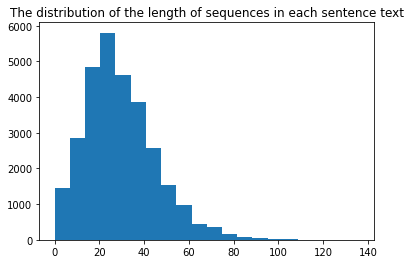

In [455]:
# get the distribution of the length of sequence in each sentence text
import matplotlib.pyplot as plt

plt.title("The distribution of the length of sequences in each sentence text")
plt.hist(seq_length, bins=20)
plt.xticks(np.arange(0, 150, 20))
plt.show()

In [456]:
# pad sequence (get the first 60/80 text sequence)
sequence_length = 60

x_train= sequence.pad_sequences(x_train_seq, maxlen=sequence_length, truncating='post', padding='post')
x_train= x_train[:, :sequence_length]

print(x_train)
print(x_train.shape)
print(x_train.dtype)

[[   1 1351   40 ...    0    0    0]
 [  27  102    2 ...    0    0    0]
 [ 741    2    3 ...    0    0    0]
 ...
 [1123  712  619 ...    0    0    0]
 [ 600    0    0 ...    0    0    0]
 [   3  201    4 ...    2    1 1360]]
(29639, 60)
int32


### processing numbers ###

In [457]:
# the counts of the numbers in each sentence, get the distribution

max_number_seq = 0
num_seq_length = list()
for i in numbers:
    num_seq_length.append(len(i))
max_number_seq = max(num_seq_length)
print("max number sequence length: ", max_number_seq)


max number sequence length:  23


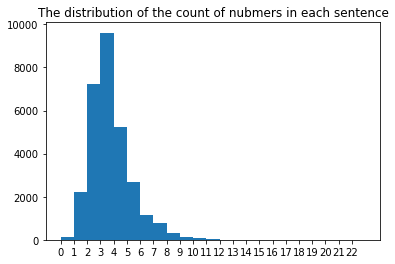

In [458]:
# get the distribution of the count of the nubmers
import matplotlib.pyplot as plt

plt.title("The distribution of the count of nubmers in each sentence")
plt.hist(num_seq_length, bins=max_number_seq)
plt.xticks(np.arange(max_number_seq))
plt.show()

In [531]:
# pad sequence (get the first 5 nubmers)
max_number_seq = 5
x_train_num = sequence.pad_sequences(numbers, dtype='float', truncating='post', padding='post')
x_train_num = x_train_num[:, :max_number_seq]

print(x_train_num)
print(x_train_num.shape)
print(x_train_num.dtype)
print(x_train_num[29288])

[[3.0000e+00 1.0000e-01 3.6000e+01 0.0000e+00 0.0000e+00]
 [4.0000e+01 1.2000e+02 3.2000e+01 4.0000e+00 0.0000e+00]
 [6.6670e-01 9.0000e+01 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [2.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.5184e+04 3.5200e+02 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.5100e+00 7.8600e+00 8.0900e+00 8.3000e+00 7.7300e+00]]
(29639, 5)
float64
[1.23456789e+80 4.50000000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


In [532]:
y_train = ans_train

### normailise the text and numbers sequences

In [533]:
print(numbers[29288])
print(x_train_num[29288])
print(train_problems[29288])

[1.23456789e+80 4.50000000e+01]
[1.23456789e+80 4.50000000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
 what is the remainder when 123456789101112131415161718192021222324252627282930313233343536373839404142434481 is divided by 45 


In [534]:
def minmax_norm(a):
    # min-max normailise the sequence of numbers
    norm_a = np.empty(a.shape)
    for i in range(len(a)):
        maxitem = np.max(a[i, :])
        minitem = np.min(a[i, :])
        norm_a[i, :] = (a[i, :] - minitem) / (maxitem - minitem + 0.0000001)
    return norm_a

norm_x_train_num = minmax_norm(x_train_num)

## 5. Model

In [537]:
# Load Glove vectors

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 300
glove_vec_file = 'dataset/glove.6B.300d.txt'
embedding_matrix = create_embedding_matrix(glove_vec_file, tok.word_index, embedding_dim)

In [538]:
vocab_size = len(tok.word_index) + 1
print(vocab_size)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
print(nonzero_elements / vocab_size)
print(embedding_matrix.shape)

8095
7570
0.9351451513279803
(8095, 300)


### building model ###

In [559]:
LSTM_DIM = 32
DROPOUT = 0.5
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
# LOSS = 'mean_squared_error'
LOSS = tf.keras.losses.MeanSquaredError()
HIDDEN_DIM = 16

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, Input
from keras.layers.merge import concatenate
from keras.layers import LayerNormalization

def buildModel(vsize, inputdim, maxlen, emb_matrix, maxnumbers):

    text_input = Input(shape=(maxlen, ))     
    numerical_input = Input(shape=(maxnumbers, ))
    
    emb = Embedding(input_dim=vsize, 
                   output_dim=inputdim, 
                   weights=[emb_matrix],
                   trainable=False)(text_input)
    
    z = LayerNormalization(axis=1)(emb)
    
    z = LSTM(LSTM_DIM)(z)
    z = Dropout(DROPOUT)(z)
    
    z = Dense(HIDDEN_DIM, activation=ACTIVATION)(z)
    
    
    numerical_input = Input(shape=(maxnumbers, ))
    
    merged = concatenate([z, numerical_input])    
    predictions = Dense(1, activation='linear')(merged)
    
    model = Model([text_input, numerical_input], outputs=predictions)
    
    model.compile(optimizer=OPTIMIZER,
                  loss = LOSS,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

model = buildModel(vocab_size, embedding_dim, sequence_length, embedding_matrix, max_number_seq)
model.summary()

Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_190 (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_64 (Embedding)        (None, 60, 300)      2428500     input_190[0][0]                  
__________________________________________________________________________________________________
layer_normalization_53 (LayerNo (None, 60, 300)      120         embedding_64[0][0]               
__________________________________________________________________________________________________
lstm_62 (LSTM)                  (None, 32)           42624       layer_normalization_53[0][0]     
___________________________________________________________________________________________

In [563]:
EPOCHS = 100
subindex1 = 0
subindex2 = 29000

m = model.fit(
#     x=[x_train[subindex1:subindex2], norm_x_train_num[subindex1:subindex2]],
#     y=y_train[subindex1:subindex2],
    x=[x_train, norm_x_train_num],
    y=y_train,
    batch_size=50,
    epochs=EPOCHS,
    verbose=True,
)

Epoch 1/10
593/593 [==============================] - 22s 37ms/step - loss: 20.6325 - rmse: 4.5423
Epoch 2/10
593/593 [==============================] - 29s 49ms/step - loss: 20.6353 - rmse: 4.5426
Epoch 3/10
593/593 [==============================] - 29s 49ms/step - loss: 20.6282 - rmse: 4.5418
Epoch 4/10
593/593 [==============================] - 27s 46ms/step - loss: 20.6346 - rmse: 4.5425
Epoch 5/10
593/593 [==============================] - 31s 53ms/step - loss: 20.6314 - rmse: 4.5422
Epoch 6/10
593/593 [==============================] - 29s 49ms/step - loss: 20.6342 - rmse: 4.5425
Epoch 7/10
593/593 [==============================] - 28s 48ms/step - loss: 20.6245 - rmse: 4.5414
Epoch 8/10
593/593 [==============================] - 28s 46ms/step - loss: 20.6243 - rmse: 4.5414
Epoch 9/10
593/593 [==============================] - 28s 46ms/step - loss: 20.6224 - rmse: 4.5412
Epoch 10/10
593/593 [==============================] - 28s 47ms/step - loss: 20.6243 - rmse: 4.5414


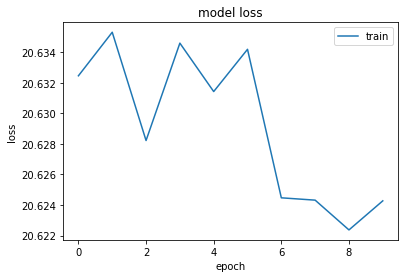

In [572]:
plt.plot(m.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [541]:
print(x_train.shape)
print(x_train_num.shape)
print(y_train.shape)

(29639, 60)
(29639, 5)
(29639,)


In [31]:
# del model

## 6. Evaluate the model

## 7. Make predictions

#### 1) processing test problems

In [549]:
def get_test_problems(test_df):
    # processing the test problem and separate the text and numbers
    
    test_problems = problem_processing(test_df['Problem'])
    print(test_problems)
    
    text = test_problems.apply(separate_text)
    numbers = test_problems.apply(separate_numbers)
    print(text)
    print(numbers)
    
    return text, numbers

In [565]:
filepath = 'dataset/MathQA/test.json'
test_df = get_data(filepath)
test_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,a shopkeeper sold an article offering a discou...,a,gain,38,27.675,30,data inadequate,none of these
1,what will be the difference between simple and...,a,gain,129,130,124,133,145
2,there are 28 stations between hyderabad and ba...,c,physics,156,167,870,352,380
3,the present population of a town is 3888 . pop...,e,gain,2500,2100,3500,3600,2700
4,the triplicate ratio of 1 : 9 is ?,e,other,1 : 0,1 : 8,1 : 7,1 : 2,1 : 729
...,...,...,...,...,...,...,...,...
2980,find the area of a parallelogram with base 20 ...,c,geometry,100 cm 2,250 cm 2,800 cm 2,296 cm 2,456 cm 2
2981,"in a garden , there are 10 rows and 14 columns...",e,physics,20 m,22 m,24 m,26 m,28 m
2982,a can do a piece of work in 6 hours ; b and c ...,d,physics,8 hours,6 hours,14 hours,12 hours,5 hours
2983,a train 250 m long running at 72 kmph crosses ...,a,physics,350 m,200 m,250 m,270 m,300 m


In [569]:
sub_test_df, test_ans = get_valid_subset(sum_norm(test_df))
sub_test_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,a shopkeeper sold an article offering a discou...,0,gain,0.397178,0.289261,0.313562,NaN,NaN
1,what will be the difference between simple and...,0,gain,0.195159,0.196672,0.187595,0.201210,0.219365
2,there are 28 stations between hyderabad and ba...,2,physics,0.081039,0.086753,0.451948,0.182857,0.197403
3,the present population of a town is 3888 . pop...,4,gain,0.173611,0.145833,0.243056,0.250000,0.187500
4,the triplicate ratio of 1 : 9 is ?,4,other,0.636618,0.070728,0.079577,0.212185,0.000891
...,...,...,...,...,...,...,...,...
2960,find the area of a parallelogram with base 20 ...,2,geometry,0.052576,0.131441,0.420610,0.155626,0.239748
2961,"in a garden , there are 10 rows and 14 columns...",4,physics,0.166667,0.183333,0.200000,0.216667,0.233333
2962,a can do a piece of work in 6 hours ; b and c ...,3,physics,0.177778,0.133333,0.311111,0.266667,0.111111
2963,a train 250 m long running at 72 kmph crosses ...,0,physics,0.255474,0.145985,0.182482,0.197080,0.218978


In [570]:
test_ans

array([0.39717795, 0.19515885, 0.45194805, ..., 0.26666667, 0.25547445,
       0.15      ])

#### 2) predicttion

In [550]:
# model.predict()

def prediction(model, tok, test_df, sequence_length, max_number_seq):
    
    # get the sequence of the text and numbers
    text, numbers = get_test_problems(test_df)
    
    x_test_seq = tok.texts_to_sequences(text)
    x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=sequence_length, truncating='post', padding='post')
#     print(x_seq)
    print(x_test_seq.shape)
    
    x_test_num_seq = sequence.pad_sequences(numbers, maxlen=max_number_seq, dtype='float32', truncating='post', padding='post')
    x_tset_num_seq = x_test_num_seq[:, :max_number_seq]
    print(x_test_num_seq)
    
    output = model.predict([x_test_seq, x_test_num_seq]) 
    return output


In [551]:
# dummy test dataset
test_df = pd.DataFrame([
    {
        "Problem": "a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount had been offered ?",
        "Rationale": "\"giving no discount to customer implies selling the product on printed price . suppose the cost price of the article is 100 . then printed price = 100 \u00e3 \u2014 ( 100 + 31.1 ) / ( 100 \u00e2 \u02c6 \u2019 5 ) = 138 hence , required % profit = 138 \u00e2 \u20ac \u201c 100 = 38 % answer a\"",
        "options": "a ) 38 , b ) 27.675 , c ) 30 , d ) data inadequate , e ) none of these",
        "correct": "a",
        "annotated_formula": "subtract(divide(multiply(add(const_100, 31.1), const_100), subtract(const_100, 5)), const_100)",
        "linear_formula": "add(n1,const_100)|subtract(const_100,n0)|multiply(#0,const_100)|divide(#2,#1)|subtract(#3,const_100)|",
        "category": "gain"
    },
    {
        "Problem": "what will be the difference between simple and compound interest at 14 % per annum on a sum of rs . 1000 after 4 years ?",
        "Rationale": "\"s . i . = ( 1000 * 14 * 4 ) / 100 = rs . 560 c . i . = [ 1000 * ( 1 + 14 / 100 ) 4 - 1000 ] = rs . 689 difference = ( 689 - 560 ) = rs . 129 answer : a\"",
        "options": "a ) 129 , b ) 130 , c ) 124 , d ) 133 , e ) 145",
        "correct": "a",
        "annotated_formula": "subtract(subtract(multiply(1000, power(add(divide(14, const_100), const_1), 4)), 1000), multiply(multiply(1000, divide(14, const_100)), 4))",
        "linear_formula": "divide(n0,const_100)|add(#0,const_1)|multiply(n1,#0)|multiply(n2,#2)|power(#1,n2)|multiply(n1,#4)|subtract(#5,n1)|subtract(#6,#3)|",
        "category": "gain"
    },
    {
        "Problem": "there are 28 stations between hyderabad and bangalore . how many second class tickets have to be printed , so that a passenger can travel from any station to any other station ?",
        "Rationale": "\"the total number of stations = 30 from 30 stations we have to choose any two stations and the direction of travel ( i . e . , hyderabad to bangalore is different from bangalore to hyderabad ) in 3 \u2070 p \u2082 ways . 30 p \u2082 = 30 * 29 = 870 . answer : c\"",
        "options": "a ) 156 , b ) 167 , c ) 870 , d ) 352 , e ) 380",
        "correct": "c",
        "annotated_formula": "multiply(add(28, const_1), add(add(28, const_1), const_1))",
        "linear_formula": "add(n0,const_1)|add(#0,const_1)|multiply(#0,#1)|",
        "category": "physics"
    },
])

In [558]:
# print(tok.word_index)

In [553]:
print(sequence_length)
print(max_number_seq)

# predict output -> the predict answer
predict_output = prediction(model, tok, test_df, sequence_length, max_number_seq)
print(predict_output)

60
5
0     a shopkeeper sold an article offering a disco...
1     what will be the difference between simple an...
2     there are 28 stations between hyderabad and b...
Name: Problem, dtype: object
0     a shopkeeper sold an article offering a disco...
1     what will be the difference between simple an...
2     there are stations between hyderabad and bang...
Name: Problem, dtype: object
0          [0.05, 0.311]
1    [0.14, 1000.0, 4.0]
2                 [28.0]
Name: Problem, dtype: object
(3, 60)
[[5.00e-02 3.11e-01 0.00e+00 0.00e+00 0.00e+00]
 [1.40e-01 1.00e+03 4.00e+00 0.00e+00 0.00e+00]
 [2.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00]]
[[9.1524169e-02]
 [1.9503288e+02]
 [3.5573595e+00]]


## 8. Calculate the distance

#### 1) get correct answer

In [554]:
cor_test_ans = get_correct_ans(test_df)
print(cor_test_ans)

num_test_ans = answers_processing(cor_test_ans)
print(num_test_ans)

NameError: name 'get_correct_ans' is not defined

#### 2) processing test options

In [ ]:
def get_test_options(test_df):
    # processing the test options and separate each option
    
    test_options = list()
    opts_label = ['a', 'b', 'c', 'd', 'e']
    
    for i in range(len(test_df['options'])):
        options = test_df.iloc[i]['options']+" ,"
        answers = list()
        for j in opts_label:
            index_s = options.find(j+" ) ")+3
            index_len = options[index_s:].find(',')
            ans = options[index_s:index_s+index_len]
            answers.append(ans)
        answers = pd.Series(answers)
        # normalizing the options
        answers = answers_processing(answers)
        test_options.append(answers)
    return test_options


In [ ]:
test_opts = get_test_options(test_df)
print(test_opts)

In [ ]:
def get_best_ans(opts, predict_output):
    # get the closest answer from teh options as the best answer
    dist = np.abs(predict_output - opts)
    print(dist)
    
    best_ans = np.min(dist)
    return best_ans

best_ans = get_best_ans(test_opts, predict_output)
print(best_ans)

## 9. categorise

1. construct a lexicon of n-grams relating to six specific domains.
2. compute the frequency of the domain related lexicons and then label the category of the problem
3. train and predict the model

In [546]:
sub_train_df

,Problem,correct,category,option_a,option_b,option_c,option_d,option_e
0,the banker ' s gain of a certain sum due 3 yea...,0,gain,0.258065,0.193548,0.322581,0.225806,NaN
1,average age of students of an adult school is ...,3,general,0.625000,0.062500,0.187500,0.125000,NaN
2,sophia finished 2 / 3 of a book . she calculat...,1,general,0.119085,0.140406,0.456058,0.138326,0.146126
3,120 is what percent of 50 ?,1,gain,0.006274,0.301129,0.062735,0.002509,0.627353
4,there are 10 girls and 20 boys in a classroom ...,0,other,0.283030,0.188667,0.113212,0.188667,0.226424
...,...,...,...,...,...,...,...,...
29634,a man invests some money partly in 10 % stock ...,0,other,0.199724,0.224712,0.266299,0.309264,NaN
29635,"average of 10 matches is 32 , how many runs on...",3,general,0.170732,0.185366,0.190244,0.239024,0.214634
29636,solve below question 2 x + 1 = - 23,2,general,0.380952,0.428571,0.571429,0.190476,-0.571429
29637,calculate 85184 ÷ ? = 352,1,general,0.198517,0.199341,0.200988,0.203460,0.197694


In [547]:
sub_train_group = sub_train_df.groupby(['category'])
sub_train_group.count()

,Problem,correct,option_a,option_b,option_c,option_d,option_e
category,,,,,,,
gain,5103,5103,5103,5103,5103,5088,4549
general,13153,13153,13134,13141,13144,13095,12158
geometry,2090,2090,2087,2087,2082,2078,1880
other,1805,1805,1804,1805,1804,1804,1702
physics,7039,7039,7027,7037,7038,7025,6459
probability,449,449,448,449,448,448,424


In [548]:
label = ['gain', 'general']

def train_subset_cat(subset, label, model):
    subset = subset[subset.category==label]
    train_problems = problem_processing(subset['Problem'])
    y_train = get_valid_subset(subset)[1]
    print(ans_train.shape)
    
    # text
    text = train_problems.apply(separate_text)
#     print(text)

    # a function to process with the sequence of text
    
    # pad sequence (get the first 60 text sequence)
    sequence_length = 60
    x_train= sequence.pad_sequences(x_train_seq, maxlen=sequence_length, truncating='post', padding='post')
    x_train= x_train[:, :sequence_length]

    # numbers
    numbers = train_problems.apply(separate_numbers)
#     print(numbers)
    
    max_number_seq = 5
    x_train_num = sequence.pad_sequences(numbers, dtype='float', truncating='post', padding='post')
    x_train_num = x_train_num[:, :max_number_seq]
    

    EPOCHS = 1

    m = model.fit(
        x=[x_train, x_train_num],
        y=y_train,
        batch_size=50,
        validation_split=0.2,
        epochs=EPOCHS,
    )
    
    
    
#     model.fit(
#         x= ,
#         y= , 
        
#     )
    
    return m.history()
    
train_subset_cat(sub_train_df, label[0], model)

(29639,)


ValueError: Data cardinality is ambiguous:
  x sizes: 23711, 5103
  y sizes: 5103
Make sure all arrays contain the same number of samples.